In [1]:
import re
import pandas as pd
import pdfplumber

In [2]:
pdf = pdfplumber.open("RBWO_FY2014_Provider_Profile_Guide.pdf")

In [3]:
len(pdf.pages)

528

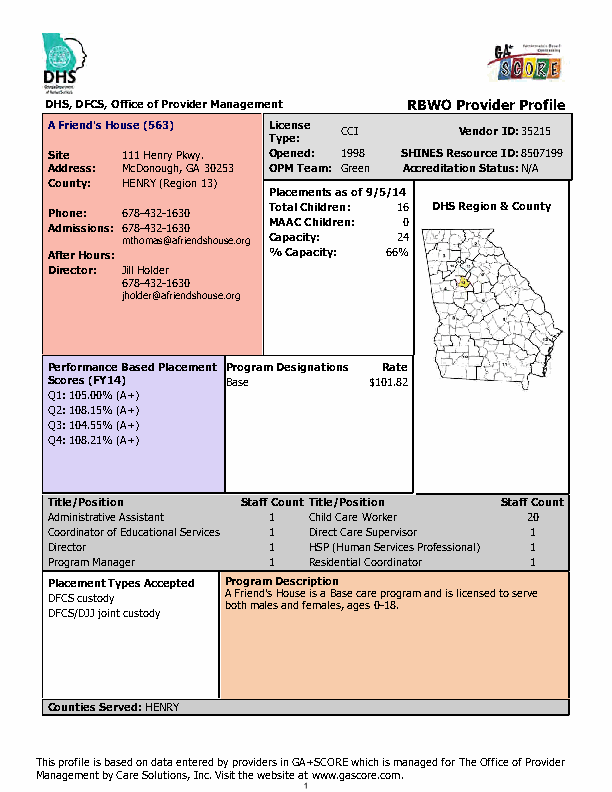

In [4]:
page = pdf.pages[9]
im = page.to_image()
im

The provider name seems to be in a different color than the rest of the pdf, so maybe that's a good way to isolate it.

In [5]:
char_colors = pd.DataFrame(page.chars)["non_stroking_color"].astype(str)

char_colors.value_counts()

(0, 0, 0)      1233
(0, 0, 0.4)      22
(0,)              1
Name: non_stroking_color, dtype: int64

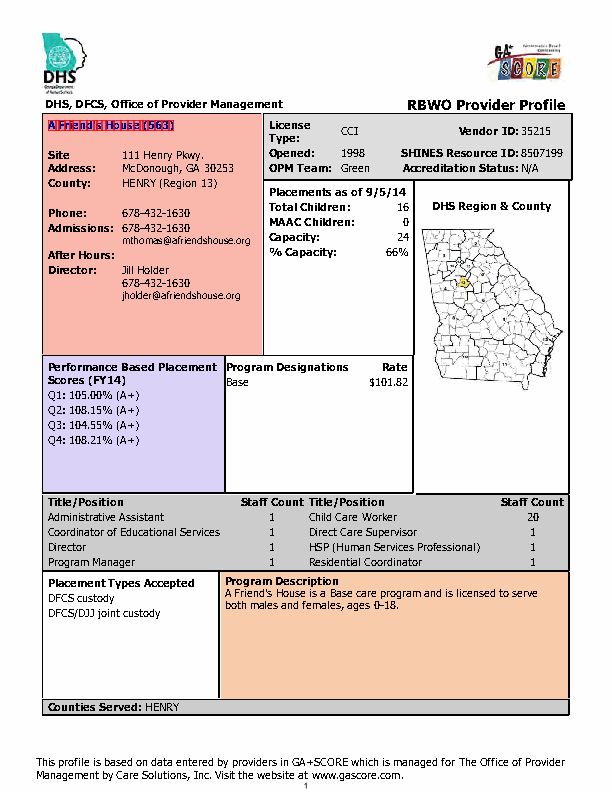

In [6]:
blue_chars = [c for c in page.chars
    if c["non_stroking_color"] == (0, 0, 0.4)]

im.reset().draw_rects(blue_chars)

In [7]:
def is_blue(obj):
    return obj.get("non_stroking_color") == (0, 0, 0.4)

provider_name = page.filter(is_blue)
provider_name = provider_name.extract_text()
print(provider_name)

A Friend's House (563)


Now let's see if we can zoom in in the square containing performance score. It also has quite a specific color.

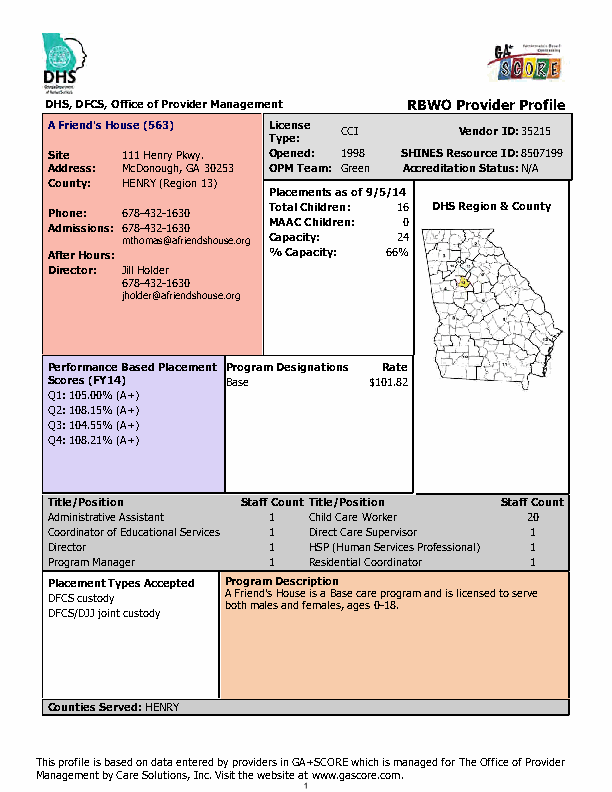

In [8]:
im.reset().draw_rects(page.rects)

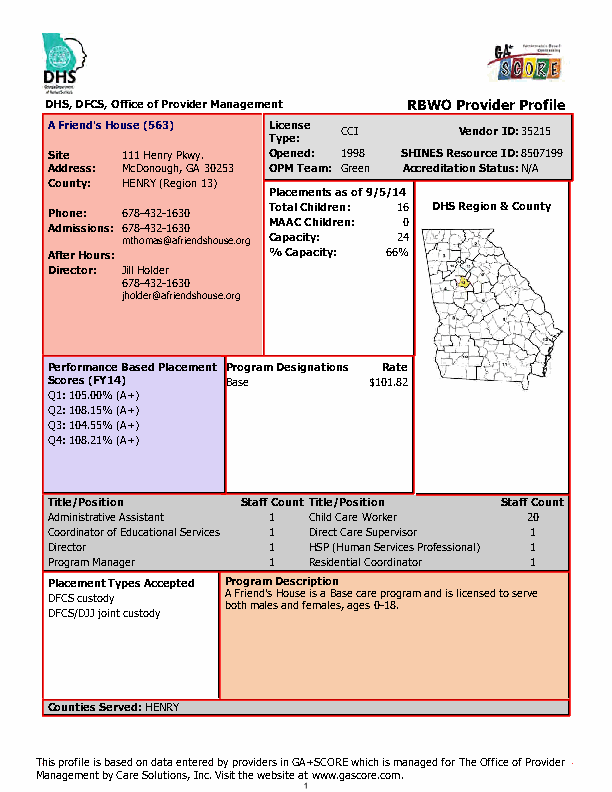

In [9]:
im.reset().draw_lines(page.lines, stroke_width=2)

Unfortunately, it seems that it is not recognized as a rectagle but instead only as lines, so the color-method might not be doable. Instead, because I expect the information to be have a constant formatting, maybe we can just use regex.

In [10]:
text = page.extract_text()
text

"DHS, DFCS, Office of Provider Management RBWO Provider Profile\nA Friend's House (563) License\nCCI Vendor ID:35215\nType:\nSite 111 Henry Pkwy. Opened: 1998 SHINES Resource ID:8507199\nAddress: McDonough, GA 30253 OPM Team: Green Accreditation Status:N/A\nCounty: HENRY (Region 13)\nPlacements as of 9/5/14\nTotal Children: 16 DHS Region & County\nPhone: 678-432-1630\nMAAC Children: 0\nAdmissions: 678-432-1630\nCapacity: 24\nmthomas@afriendshouse.org\nAfter Hours: % Capacity: 66%\nDirector: Jill Holder\n678-432-1630\njholder@afriendshouse.org\nPerformance Based Placement Program Designations Rate\nScores (FY14) Base $101.82\nQ1: 105.00% (A+)\nQ2: 108.15% (A+)\nQ3: 104.55% (A+)\nQ4: 108.21% (A+)\nTitle/Position Staff Count Title/Position Staff Count\nAdministrative Assistant 1 Child Care Worker 20\nCoordinator of Educational Services 1 Direct Care Supervisor 1\nDirector 1 HSP (Human Services Professional) 1\nProgram Manager 1 Residential Coordinator 1\nPlacement Types Accepted Program D

In [11]:
# Find all Q percentages
q_matches = re.findall(r"(Q\d): (\d+\.\d+)%", text)

# Convert to DataFrame
df = pd.DataFrame(q_matches, columns=['quarter', 'score'])

# Convert the 'Percentage' column to float
df['score'] = df['score'].astype(float)

df

,quarter,score
0,Q1,105.00
1,Q2,108.15
2,Q3,104.55
3,Q4,108.21


In [18]:
df['provider_name'] = re.sub(r'\(\d+\)', '', provider_name)
df['provider_id'] = re.findall(r'\((\d+)\)', provider_name)[0]
df

,quarter,score,provider_name,provider_id
0,Q1,105.00,A Friend's House,563
1,Q2,108.15,A Friend's House,563
2,Q3,104.55,A Friend's House,563
3,Q4,108.21,A Friend's House,563


### Now we "just" have to loop through pages and append the results

In [22]:
def is_blue(obj):
    return obj.get("non_stroking_color") == (0, 0, 0.4)

results = []

for page in pdf.pages:
    
    # Getting provider name and ID
    provider_name = page.filter(is_blue)
    
    if not provider_name:  # if no blue objects, continue to next page
        continue
    
    
    provider_name = provider_name.extract_text()
    
    if not provider_name:  # if no text in blue object, continue to next page
        continue
    
    print(provider_name)
    
    # Getting quarters and scores
    text = page.extract_text()
    # Find all Q percentages
    q_matches = re.findall(r"(Q\d): (\d+\.\d+)%", text)
    
    if not q_matches:  # if no matches, continue to next page
        continue


    # Convert to DataFrame
    df = pd.DataFrame(q_matches, columns=['quarter', 'score'])

    # Convert the 'Percentage' column to float
    df['score'] = df['score'].astype(float)
    
    # Adding provider name and ID to the df
    df['provider_name'] = re.sub(r'\(\d+\)', '', provider_name)
    df['provider_id'] = re.findall(r'\((\d+)\)', provider_name)[0]
    
    # Appending the df to results
    results.append(df)
    
results
    

    
    
    

A Friend's House (563)
Advocates for Bartow's Children
Flowering Branch Children's Shelter
(564)
Agape Behavioral Healthcare, Inc.
(694)
Alyssa and Brothers, Inc. dba Rowley
Residence #2 (908)
AMI Kids Savannah River (5161)
Appalachian Children's Emergency
Shelter (5167)
Ark Family Counseling Center, The
Ricky Homes/Dallas (569)
Ark Family Counseling Center, The
Ricky Homes/Decatur (571)
Ark Family Counseling Center, The
Ricky Homes/Lithonia (591)
Ark Family Counseling Center, The
Ricky Homes/Powder Springs (570)
Bald Ridge Lodge, Inc. Bald Ridge
Lodge (4124)
Behavioral Health Services of South
GA dba Lowndes C & A North Point
Group Home (Valdosta) (866)
Beth-Ester Ministries dba
Restoration House 1 (817)
Beth-Ester Ministries Restoration
House ILP (5170)
Broken Shackle Ranch (576)
Carl Malone Foundation, Inc. Mercy's
Door - IV (5142)
Carl Malone Foundation, Inc. Mercy's
Door I (993)
Carl Malone Foundation, Inc. Mercy's
Door II (994)
Carl Malone Foundation, Inc. Mercy's
Door III (1041)

Twin Cedars Youth Services Bradfield
Center (846)
Twin Cedars Youth Services
Connections (837)
Twin Cedars Youth Services
Magnolia Second Chance Home (844)
Twin Cedars Youth Services Reality
House (841)
Twin Cedars Youth Services
Weracoba Second Chance Home
(937)
United Methodist Children Home of
the North GA Conference
Independent Living Program (4428)
United Methodist Children Home of
the North GA Conference On-Campus
Transitional Living Program (Hybrid)
(849)
United Methodist Children Home of
the North GA Conference Second
Chance (5123)
Vanessa's Place (5162)
Vanessa's Place ILP (5177)
Vashti Center, The (852)
Vision Youth Services Boys (5125)
Vision Youth Services Girls (5124)
Visions of Hope for Boys (978)
Weekes House, Inc. Weekes House
(5178)
Wellspring Living, Inc. (5168)
Young Adult Guidance Center, The
(860)
Youth Villages (Inner Harbour
Campus) Douglas Center: Girls (624)
Youth Villages (Inner Harbour
Campus) Douglasville: The Ranch
Boys (711)
Youth Villages (Inner Harbour
C

[  quarter   score      provider_name provider_id
 0      Q1  105.00  A Friend's House          563
 1      Q2  108.15  A Friend's House          563
 2      Q3  104.55  A Friend's House          563
 3      Q4  108.21  A Friend's House          563,
   quarter  score                                      provider_name  \
 0      Q1  96.59  Advocates for Bartow's Children\nFlowering Bra...   
 1      Q2  92.75  Advocates for Bartow's Children\nFlowering Bra...   
 2      Q3  93.28  Advocates for Bartow's Children\nFlowering Bra...   
 3      Q4  90.98  Advocates for Bartow's Children\nFlowering Bra...   
 
   provider_id  
 0         564  
 1         564  
 2         564  
 3         564  ,
   quarter  score                        provider_name provider_id
 0      Q1  85.32  Agape Behavioral Healthcare, Inc.\n         694
 1      Q2  78.53  Agape Behavioral Healthcare, Inc.\n         694
 2      Q3  54.94  Agape Behavioral Healthcare, Inc.\n         694
 3      Q4  72.67  Agape Behavior

In [24]:
df = pd.concat(results, ignore_index=True)

df.head(20)

,quarter,score,provider_name,provider_id
0,Q1,105.00,A Friend's House,563
1,Q2,108.15,A Friend's House,563
2,Q3,104.55,A Friend's House,563
3,Q4,108.21,A Friend's House,563
4,Q1,96.59,Advocates for Bartow's Children\nFlowering Bra...,564
5,Q2,92.75,Advocates for Bartow's Children\nFlowering Bra...,564
6,Q3,93.28,Advocates for Bartow's Children\nFlowering Bra...,564
7,Q4,90.98,Advocates for Bartow's Children\nFlowering Bra...,564
8,Q1,85.32,"Agape Behavioral Healthcare, Inc.\n",694
9,Q2,78.53,"Agape Behavioral Healthcare, Inc.\n",694


In [26]:
df['provider_name'] = df['provider_name'].str.replace('\n', '')
df.tail(20)

,quarter,score,provider_name,provider_id
879,Q1,91.24,"Omni Visions, Inc. Tucker (formerlyPhoenix Hom...",4934
880,Q2,96.03,"Omni Visions, Inc. Tucker (formerlyPhoenix Hom...",4934
881,Q3,82.87,"Omni Visions, Inc. Tucker (formerlyPhoenix Hom...",4934
882,Q4,90.90,"Omni Visions, Inc. Tucker (formerlyPhoenix Hom...",4934
883,Q1,98.54,"Trinity J and D, LLC Trinity J and D,LLC",980
884,Q2,99.89,"Trinity J and D, LLC Trinity J and D,LLC",980
885,Q3,98.37,"Trinity J and D, LLC Trinity J and D,LLC",980
886,Q4,97.55,"Trinity J and D, LLC Trinity J and D,LLC",980
887,Q1,90.01,Twin Cedars Youth Services FosterCare,932
888,Q2,92.78,Twin Cedars Youth Services FosterCare,932


In [29]:
df = df [
    [
    'provider_name',
    'provider_id',
    'quarter',
    'score'
    ]
]
df

,provider_name,provider_id,quarter,score
0,A Friend's House,563,Q1,105.00
1,A Friend's House,563,Q2,108.15
2,A Friend's House,563,Q3,104.55
3,A Friend's House,563,Q4,108.21
4,Advocates for Bartow's ChildrenFlowering Branc...,564,Q1,96.59
...,...,...,...,...
894,United Methodist Children Home of the North GA...,847,Q4,94.75
895,Universal Health Services ofSavannah Coastal H...,990,Q1,91.49
896,Universal Health Services ofSavannah Coastal H...,990,Q2,86.74
897,Universal Health Services ofSavannah Coastal H...,990,Q3,87.21


In [30]:
df.to_csv('RBWO_providers_DallaStella.csv')